In [79]:
import numpy as np

from box.boxio import generate_integrated_xyxy_list

In [80]:
det_path = "../datasets/casia/test_face_moving/detection/"

In [81]:
# 検出を統合したリストの作成
conf_list, box_list = generate_integrated_xyxy_list(det_path)
conf_list = conf_list.numpy()
box_list = box_list.numpy()

In [82]:
# 座標を分割し、グリッドを作成する
x_grid = np.linspace(min(box_list[:,0]), max(box_list[:,0]), num=100)
y_grid = np.linspace(min(box_list[:,1]), max(box_list[:,1]), num=100)
x_mesh_grid, y_mesh_grid = np.meshgrid(x_grid, y_grid)

In [83]:
# 分割した座標に合わせて元の座標を変換する
x_indices = np.digitize(box_list[:,0], x_grid) - 1
y_indices = np.digitize(box_list[:,1], y_grid) - 1

In [84]:
# 
grid_freq = np.zeros((len(y_grid), len(x_grid)), dtype=int)
for i in range(len(x_indices)):
    grid_freq[y_indices[i], x_indices[i]] += 1


In [85]:
import matplotlib.pyplot as plt

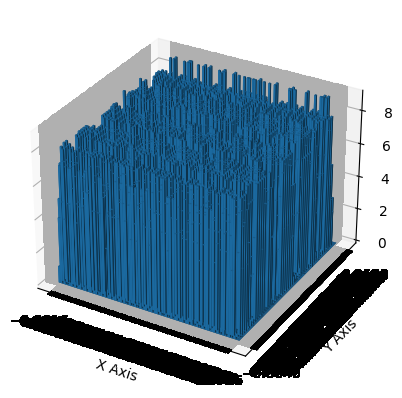

In [86]:
# グリッドポイントの頻度を3Dグラフとしてプロット
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 頻度を3Dバーとしてプロット
ax.bar3d(x_mesh_grid.flatten(), y_mesh_grid.flatten(), np.zeros_like(grid_freq).flatten(),
         (np.ones_like(grid_freq)/grid_freq.shape[1]).flatten(), (np.ones_like(grid_freq)/grid_freq.shape[0]).flatten(), grid_freq.flatten(), shade=True)

# 軸ラベルの設定
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Frequency')

# グリッドの設定
ax.set_xticks(x_mesh_grid.flatten())
ax.set_yticks(y_mesh_grid.flatten())

# グラフの表示
plt.show()

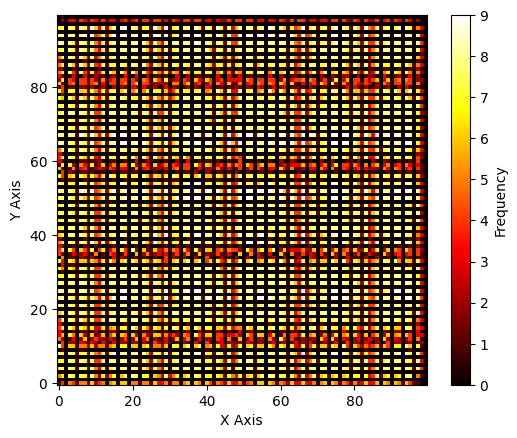

In [87]:
plt.figure()
plt.imshow(grid_freq, origin='lower', cmap='hot')
plt.colorbar(label='Frequency')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()

In [88]:
x_indices.shape


(24654,)